U ovoj skripti ćemo primeniti prvu strategiju balansiranja podataka

Podaci koje koristimo za balansiranje su ocisceni_podaci_sa_tonom_koze.csv

Trenutno se u podacima nalazi 575 pacijenata sa malignom slikom, dok je njih 31956 sa beningom

Ovaj odnos koji je priblizno jednak 1:55 je neprihvatljiv za treniranje modela. Moraju se koristiti tehnike undersamplinga vecinske klase i oversamplinga manjinske klase kako bi odnos podataka postao prihvatljiv

Ova skripta ce sadrzati obe navedene metode, a ciljani odnos ce biti 1:5

Bitna napomena je da trenutno u podacima postoji kolona skin_tone, na koju se mora obratiti paznja. Cilj je da prilikom balansiranja obezbedimo priblizno jednak broj podataka od svake klase(tona koze).

In [1]:
import pandas as pd
import os
from notebooks.exploration.plot_utils import plot_skin_tone_distribution_v2

In [2]:
df = pd.read_csv("ocisceni_podaci_sa_tonom_koze_kopija.csv")

In [3]:
print(len(df))

32531


In [4]:
print(df['target'].value_counts())

target
0    31956
1      575
Name: count, dtype: int64


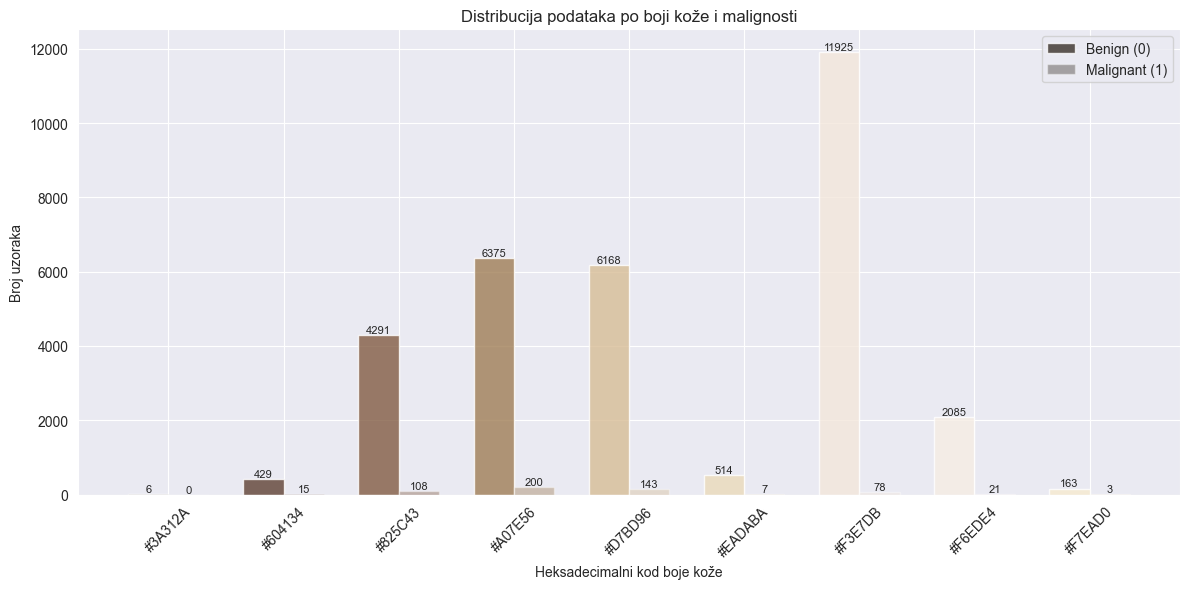

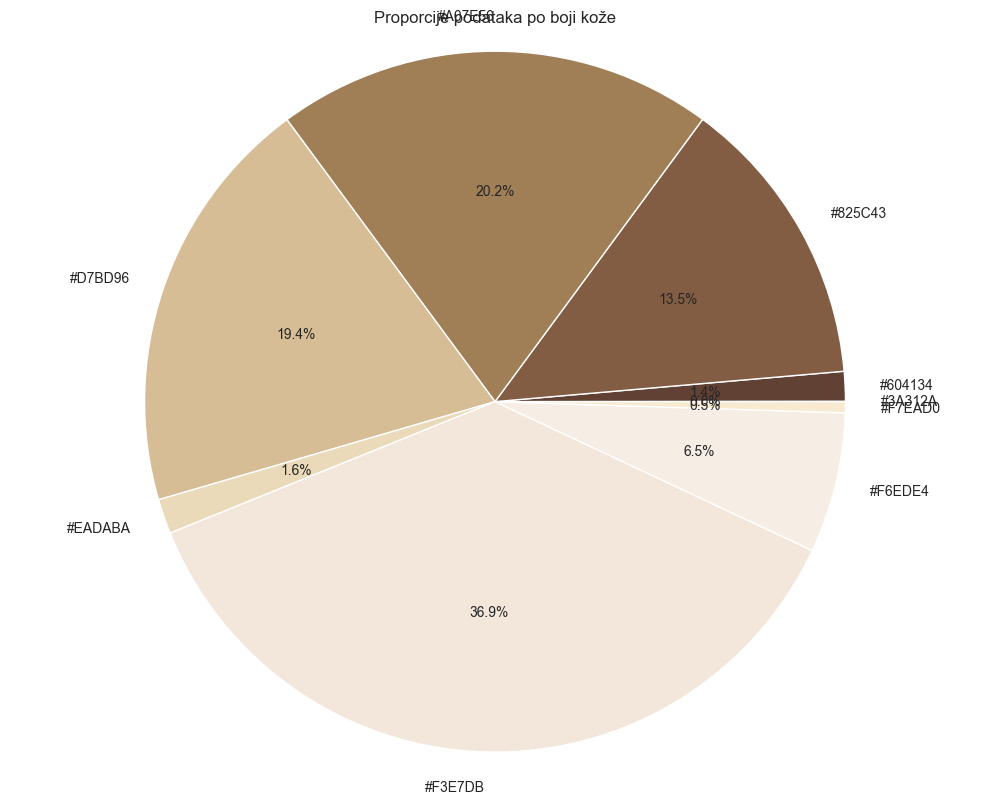

In [5]:
#zelimo da prikazemo raspodelu podatka po boji koze, pored toga je dodatno ukazano na to koji predstavnici su beningi a koji maligni
plot_skin_tone_distribution_v2(df)

Na bar plotu se moze primetiti da je broj podataka po tonu koze veoma razlicit. To znaci da ce za razlicite tonove koze biti upotrebljene razlicite metode balansiranja

Vidimo da jedna kategorija sadrzi samo 6 podataka, sto je nedovoljno za bilo kakvu augmentaciju. Ovu kolonu cemo izbaciti(obrisati 6 podataka)

In [6]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,skin_tone
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,#F3E7DB
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,#D7BD96
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,#604134
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,#604134
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,#D7BD96


In [7]:
#brisanje podataka sa tonom koze #3A312A
df = df[df['skin_tone'] != '#3A312A']

In [8]:
#provera
print(len(df))

32525


Cilj ove strategije balansiranja jeste da napravimo odnos 1:5. To cemo postici tako sto vecinsku klasu smanjimo na otprilike 10000 podataka, a manjinsku klasu povecamo na otprilike 2000 podataka

Posto sada ima 8 klasa onda je cilj da svaka klasa ima priblizno 1000 benignih predstavnika i 200 malignih predstavnika

In [9]:
# Razdvajamo benigne i maligne
benign_df = df[df['target'] == 0]
malignant_df = df[df['target'] == 1]

In [10]:
#u ovoj celiji cemo odstraniti visak podataka u klasama koje imaju vise od 1100 benignih predstavnika
# Grupisanje benignih po skin_tone i uzimanje do 1100 nasumično po grupi
benign_temp = (
    benign_df.groupby('skin_tone')
    .apply(lambda x: x.sample(n=1000, random_state=42) if len(x) > 1000 else x)
    .reset_index(drop=True)
)

C:\Users\Marko\AppData\Local\Temp\ipykernel_12680\295571565.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=1000, random_state=42) if len(x) > 1000 else x)


In [11]:
# Spajanje sa malignim nazad
df = pd.concat([benign_temp, malignant_df], ignore_index=True)

In [12]:
#provera
print(df[df['target'] == 0]['skin_tone'].value_counts())

skin_tone
#825C43    1000
#A07E56    1000
#D7BD96    1000
#F3E7DB    1000
#F6EDE4    1000
#EADABA     514
#604134     429
#F7EAD0     163
Name: count, dtype: int64


Sada je potrebno izvrsiti augmentaciju onih klasa kojih ima manje od 1000

In [13]:
#Ucitavanje dataset-a sa slikama
data_dir = 'C:/Users/Marko/MELANOMA/ISIC_2020_Training_JPEG/train'
os.listdir(data_dir)[0]

'aug_ISIC_0052212_0.jpg'

In [14]:
#poseban df za preostale tonove koze
df_EADABA = df[(df['skin_tone'] == '#EADABA') & (df['target'] == 0)]
df_604134 = df[(df['skin_tone'] == '#604134') & (df['target'] == 0)]
df_F7EAD0= df[(df['skin_tone'] == '#F7EAD0') & (df['target'] == 0)]

In [15]:
#provera
print(len(df_EADABA))
print(len(df_604134))
print(len(df_F7EAD0))

514
429
163


In [16]:
# Izvlacimo listu naziva fajlova slika iz DataFrame-a za augmentaciju
images_EADABA_to_augment = df_EADABA['image_name'].tolist()
images_604134_to_augment = df_604134['image_name'].tolist()
images_F7EAD0_to_augment = df_F7EAD0['image_name'].tolist()

In [17]:
import sys
sys.path.append('scripts')
from Augmentacija import Augmentation
from augmentacija_funkcija import augment_images
from PIL import Image
import random

In [18]:
#instanca klase Augmentation
augment = Augmentation()

In [19]:
#lista mogucih augmentacija slika
augmentation_functions = [
    augment.brightness,
    augment.contrast,
    augment.color_jitter,
    augment.gaussian_noise,
    augment.blur,
    augment.crop_resize,
    augment.zoom,
]

In [21]:
df = augment_images(
    df = df,
    data_dir= data_dir,
    num_generated_per_image=1,
    images_to_augment=images_EADABA_to_augment,
    augmentations=augmentation_functions
)

In [22]:
df = augment_images(
    df = df,
    data_dir= data_dir,
    num_generated_per_image=1,
    images_to_augment=images_604134_to_augment,
    augmentations=augmentation_functions
)

In [23]:
df = augment_images(
    df = df,
    data_dir= data_dir,
    num_generated_per_image=5,
    images_to_augment=images_F7EAD0_to_augment,
    augmentations=augmentation_functions
)

In [24]:
#provera
print(len(df))

8439


In [25]:
#provera
print(df[df['target'] == 0]['skin_tone'].value_counts())

skin_tone
#EADABA    1028
#825C43    1000
#D7BD96    1000
#A07E56    1000
#F6EDE4    1000
#F3E7DB    1000
#F7EAD0     978
#604134     858
Name: count, dtype: int64


In [26]:
# Cuvanje ažurirani DataFrame u novi CSV fajl
df.to_csv('sredjeni_benigni_novo.csv', index=False)

Sada treba srediti maligne podatke. Buduci da je trazeni broj malignih podataka oko 2000, onda cemo ciljati da bude 250 malignih podataka za svaki ton koze. Posto nijedna klasa nema dovoljan broj malignih predstavnika, onda je potrebno svaku klasu augmentovati odredjen broj puta

Podaci su vec razdvojeni na benigne i maligne

In [27]:
print(len(malignant_df))

575


In [28]:
print(malignant_df['skin_tone'].value_counts())

skin_tone
#A07E56    200
#D7BD96    143
#825C43    108
#F3E7DB     78
#F6EDE4     21
#604134     15
#EADABA      7
#F7EAD0      3
Name: count, dtype: int64


Ove poslednje 4 klase imaju izuzetno malu zastupljenost malignih podataka i njih moramo augmentovati svih 7 mogucih puta

In [34]:
#spajamo poslednje 4 klase u jedan df
malignant_df_to_augment = malignant_df[(malignant_df['skin_tone'] == '#F6EDE4') | (malignant_df['skin_tone'] == '#604134') | (malignant_df['skin_tone'] == '#EADABA') | (malignant_df['skin_tone'] == '#F7EAD0')]

In [35]:
#provera
print(malignant_df_to_augment['skin_tone'].value_counts())

skin_tone
#F6EDE4    21
#604134    15
#EADABA     7
#F7EAD0     3
Name: count, dtype: int64


In [37]:
# Izvlacimo listu naziva fajlova slika iz DataFrame-a za augmentaciju
malignant_images_to_augment = malignant_df_to_augment['image_name'].tolist()

In [38]:
df = augment_images(
    df = df,
    data_dir= data_dir,
    num_generated_per_image=7,
    images_to_augment=malignant_images_to_augment,
    augmentations=augmentation_functions
)

Prve 4 klase imaju zadovoljavajucu zastupljenost malignih podataka, pa cemo te klase augmentovati samo jednom

In [40]:
#spajamo prve 4 klase u jedan df
malignant_df_to_augment = malignant_df[(malignant_df['skin_tone'] == '#A07E56') | (malignant_df['skin_tone'] == '#D7BD96') | (malignant_df['skin_tone'] == '#825C43') | (malignant_df['skin_tone'] == '#F3E7DB')]

In [41]:
#provera
print(malignant_df_to_augment['skin_tone'].value_counts())

skin_tone
#A07E56    200
#D7BD96    143
#825C43    108
#F3E7DB     78
Name: count, dtype: int64


In [42]:
# Izvlacimo listu naziva fajlova slika iz DataFrame-a za augmentaciju
malignant_images_to_augment = malignant_df_to_augment['image_name'].tolist()

In [44]:
df = augment_images(
    data_dir= data_dir,
    num_generated_per_image=1,
    images_to_augment=malignant_images_to_augment,
    augmentations=augmentation_functions
)

In [48]:
#provera
print(df['skin_tone'].value_counts())

skin_tone
#A07E56    1400
#D7BD96    1286
#825C43    1216
#F6EDE4    1168
#F3E7DB    1156
#EADABA    1084
#F7EAD0    1002
#604134     978
Name: count, dtype: int64


In [49]:
# Cuvanje ažurirani DataFrame u novi CSV fajl
df.to_csv('balansirani_podaci.csv', index=False)